In [1]:
%tensorflow_version 2.x
import tensorflow as tf
from matplotlib import pyplot as plt
import time
import os

from IPython import display
print( tf.__version__)

2.2.0-rc2


In [2]:
!pip install -U tensorboard

Requirement already up-to-date: tensorboard in /usr/local/lib/python3.6/dist-packages (2.2.0)


In [ ]:
# Some Parameters
OUT_CHANNELS = 3
SHUFFLE_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [ ]:
class ConvBatchReluEncode(tf.keras.layers.Layer):
  def __init__(self, filters, size, batch_norm=True):
    super(ConvBatchReluEncode, self).__init__()
    self.layers = []
    conv = tf.keras.layers.Conv2D(filters=filters, kernel_size=size, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(0., 0.02))
    relu = tf.keras.layers.LeakyReLU(alpha=0.2)

    self.layers.append(conv)
    if batch_norm:
      self.layers.append(tf.keras.layers.BatchNormalization())
    self.layers.append(relu)
  
  def call(self, inputs, training=False):
    x = inputs
    for layer in self.layers:
      x = layer(x)
    return x


In [ ]:
class ConvBatchReluDecode(tf.keras.layers.Layer):
  def __init__(self, filters, size, dropout=False):
    super(ConvBatchReluDecode, self).__init__()
    self.layers = []
    conv = tf.keras.layers.Conv2DTranspose(filters=filters, kernel_size=size, strides=2,
                                    padding='same',
                                    kernel_initializer=tf.random_normal_initializer(0., 0.02),
                                    use_bias=False) # why no bias?
                                    
    bn = tf.keras.layers.BatchNormalization()
    relu = tf.keras.layers.ReLU()

    self.layers.append(conv)
    self.layers.append(bn)
    if dropout:
      self.layers.append(tf.keras.layers.Dropout(0.5))
    self.layers.append(relu)
  
  def call(self, inputs, training=False):
    x = inputs
    for layer in self.layers:
      x = layer(x)
    return x

In [ ]:
class Generator(tf.keras.Model):
  def __init__(self):
    super(Generator, self).__init__()

    self.encode = [
              ConvBatchReluEncode(64, 4, batch_norm=False), 
              ConvBatchReluEncode(128, 4), 
              ConvBatchReluEncode(256, 4), 
              ConvBatchReluEncode(512, 4), 
              ConvBatchReluEncode(512, 4), 
              ConvBatchReluEncode(512, 4), 
              ConvBatchReluEncode(512, 4), 
              ConvBatchReluEncode(512, 4), 
    ]

    # u-net decoder
    self.decode = [
              ConvBatchReluDecode(512, 4, dropout=True), 
              ConvBatchReluDecode(1024, 4, dropout=True),
              ConvBatchReluDecode(1024, 4, dropout=True), 
              ConvBatchReluDecode(1024, 4), 
              ConvBatchReluDecode(1024, 4), 
              ConvBatchReluDecode(512, 4),
              ConvBatchReluDecode(256, 4), 
              ConvBatchReluDecode(128, 4), 
    ]

    self.last = tf.keras.layers.Conv2DTranspose(filters=OUT_CHANNELS, kernel_size=4,
                                          strides=2,
                                          padding='same',
                                          kernel_initializer=tf.random_normal_initializer(0., 0.02),
                                          activation='tanh') # (bs, 256, 256, 3)

  def call(self, inputs):
    x = inputs
    skips = []
    # save the output of each encoding layer in a list
    for enc in self.encode:
      x = enc(x)
      skips.append(x)

    # remove the last element, because x is equal to this element (there is no skip)
    skips.pop()
    # reverse the list, because the last added skip is the first we want to access (we use it like a stack)
    skips.reverse()

    # decoding and establishing the skip connections by concatenating
    for dec, skip in zip(self.decode, skips):
      x = dec(x)
      x = tf.keras.layers.Concatenate()([x, skip])

    x = self.last(x)
    
    return x

In [ ]:
class Discriminator(tf.keras.Model):
  """"70x70 Discriminator"""
  
  def __init__(self):
    super(Discriminator, self).__init__()

    self.enc1 = ConvBatchReluEncode(64, 4, batch_norm=False) 
    self.enc2 = ConvBatchReluEncode(128, 4) 
    self.enc3 = ConvBatchReluEncode(256, 4) 
    self.conv = tf.keras.layers.Conv2D(512, 4, strides=1, padding='same',
                                kernel_initializer=tf.random_normal_initializer(0., 0.02),
                                use_bias=False)

    self.bn = tf.keras.layers.BatchNormalization()


    self.relu = tf.keras.layers.LeakyReLU(alpha=0.2)


    self.last = tf.keras.layers.Conv2D(1, 4, strides=1, padding='same',
                                kernel_initializer=tf.random_normal_initializer(0., 0.02))

  def call(self, inputs, targets, training=False):
    x = tf.keras.layers.concatenate([inputs, targets]) 
    
    x = self.enc1(x)
    x = self.enc2(x)
    x = self.enc3(x)
    x = self.conv(x)
    x = self.bn(x)
    x = self.relu(x)

    x = self.last(x)
    
    return x

In [8]:
# download the dataset
_URL = 'https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/maps.tar.gz'

path_to_zip = tf.keras.utils.get_file('maps.tar.gz',
                                      origin=_URL,
                                      extract=True)

PATH = os.path.join(os.path.dirname(path_to_zip), 'maps/')
print(PATH)

250249216/250242400 [==============================] - 2s 0us/step
/root/.keras/datasets/maps/


In [ ]:
def load_img(img_path):
  img = tf.io.read_file(img_path)

  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=OUT_CHANNELS)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  width = tf.shape(img)[1]
  
  # the original and input image are one combined image and are separated
  width = width // 2
  input_image = img[:, width:, :]
  real_image = img[:, :width, :]
  # resize the image to the desired size.
  return tf.image.resize(real_image, [IMG_WIDTH, IMG_HEIGHT]), tf.image.resize(input_image, [IMG_WIDTH, IMG_HEIGHT])



In [ ]:
def visualize(original, input_img):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('original image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('input image')
  plt.imshow(input_img)


In [ ]:
# See 6.2 Training details!

def random_jitter(original_img, input_img):
  # resize the images to 286*286*3
  original_img = tf.image.resize(original_img, [286, 286])
  input_img = tf.image.resize(input_img, [286, 286])

  # We combine both images so we get a 286*286*6 image 
  # This make cropping possible where both images are cropped the same way. 
  combined = tf.concat([original_img, input_img], axis=2)
  image_shape = tf.shape(input_img)
  
  # We reduce the size to 256*256*6 with a random_crop() 
  combined_crop = tf.image.random_crop(
      combined,
      size=[IMG_WIDTH, IMG_HEIGHT, 2*OUT_CHANNELS])

  # seperate and return both images 
  return (combined_crop[:, :, :OUT_CHANNELS],
          combined_crop[:, :, OUT_CHANNELS:])
  
    
# for architecture label -> photo
# magic number when to flip TODO
def mirror_img(original_img, input_img, chance=0.3):
  if(tf.random.uniform([1]) > chance): 
    original_img = tf.image.flip_left_right(original_img)
    input_img = tf.image.flip_left_right(input_img)
  return original_img, input_img
    

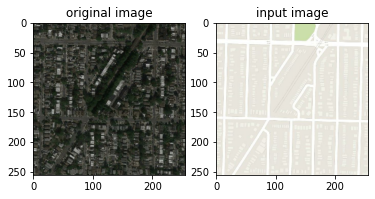

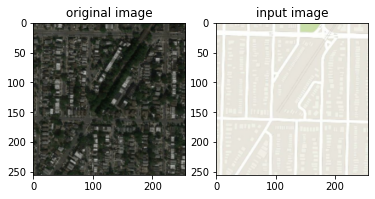

In [12]:
# Example of jitter (crop and flip)
image_file = PATH+'train/303.jpg'

real, inp = load_img(image_file)
visualize(real, inp)

real, inp = random_jitter(real, inp)
real, inp = mirror_img(real, inp)
visualize(real, inp)

In [ ]:
LAMBDA = 100 # got this from the tutorial. Is the number for lambda somewhere?
binary_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Define the loss for the generator.
def generator_loss(discriminator_generated, generated_img, target):

  # just the mean absolute error (L1)
  l1_loss = tf.reduce_mean(tf.abs(target - generated_img))

  # gan loss 
  gan_loss = binary_loss(tf.ones_like(discriminator_generated), discriminator_generated)

  combined_loss = gan_loss + LAMBDA * l1_loss

  return combined_loss

# Define the loss for the discriminator.
def discriminator_loss(discriminator_real, discriminator_generated):
  # Loss for real image - should be labeld as correct
  real_loss = binary_loss(tf.ones_like(discriminator_real), discriminator_real)
  # Loss for generated image - should be labeld as false
  generated_loss = binary_loss(tf.zeros_like(discriminator_generated), discriminator_generated)

  # return combined loss
  return real_loss + generated_loss

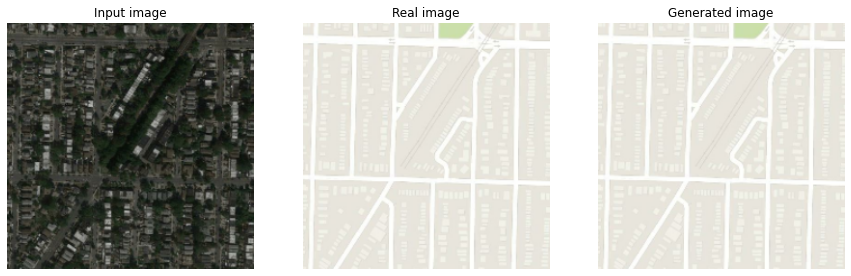

In [14]:
def plot_result(input_img, real_img, generated_img):
  input_img = tf.reshape(input_img, shape=[256, 256, 3])
  real_img = tf.reshape(real_img, shape=[256, 256, 3])
  generated_img = tf.reshape(generated_img, shape=[256, 256, 3])

  plt.figure(figsize=(15,15))
  plt.subplot(1, 3, 1)
  plt.title("Input image")
  plt.imshow(input_img)
  plt.axis("off")

  plt.subplot(1, 3, 2)
  plt.title("Real image")
  plt.imshow(real_img)
  plt.axis("off")

  plt.subplot(1, 3, 3)
  plt.title("Generated image")
  plt.imshow(generated_img)
  plt.axis("off")
  plt.show()
  
#test
plot_result(real, inp, inp)

In [ ]:
EPOCHS = 20


#MAKE DATASET
def get_train_img(img_path):
  original_img, input_img = load_img(img_path)
  original_img, input_img = random_jitter(original_img, input_img)
  original_img, input_img = mirror_img(original_img, input_img)
  return original_img, input_img

list_train_ds = tf.data.Dataset.list_files(PATH+'train/*.jpg')
train_dataset = list_train_ds.map(get_train_img)
train_dataset = train_dataset.shuffle(SHUFFLE_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)
list_test_ds = tf.data.Dataset.list_files(PATH+'val/*.jpg')
test_dataset = list_test_ds.map(load_img)
test_dataset = train_dataset.batch(BATCH_SIZE)


In [21]:
%load_ext tensorboard
%tensorboard --logdir {"logs/"}

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


<IPython.core.display.Javascript object>

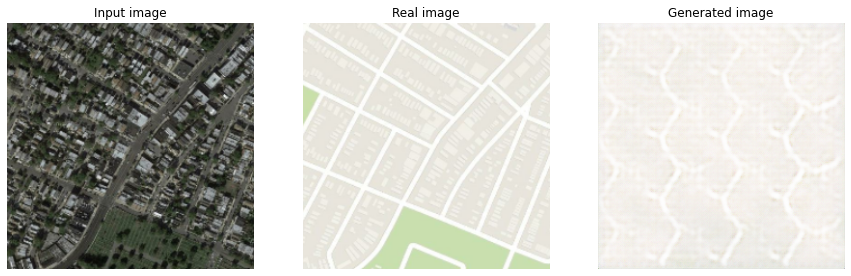

Epoch:  0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


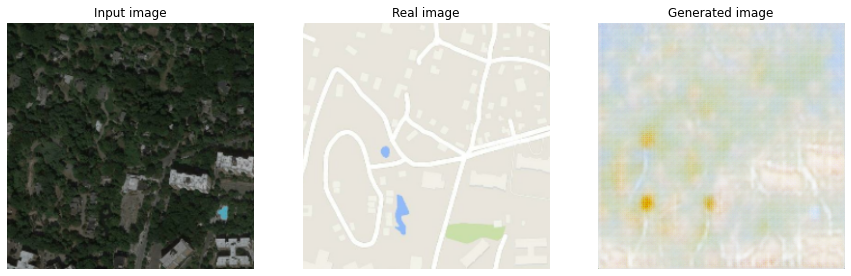

Epoch:  1


KeyboardInterrupt: ignored

In [22]:
!rm -rf ./logs/ 
import datetime
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
test_log_dir = 'logs/gradient_tape/' + current_time + '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

# For me the in-notebook tensorboard sometimes doesn't work. In this case maybe just use your terminal
# if you work on your own machine. (comment out the following line)
#%tensorboard --logdir logs/

tf.keras.backend.clear_session()

# Initialzing generator and discriminator.
generator = Generator()
discriminator = Discriminator()


# Initialize two optimizers (one for generator, one for discriminator).
# During training you will have to do every step twice (computing loss, computing gradients,
# applying gradients, storing loss in summary). Namely once for generator and once for discriminator.
gen_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5, beta_2=0.999)
dis_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5, beta_2=0.999)

for epoch in range(EPOCHS):

  for input_img, real_img in train_dataset:
    with tf.GradientTape() as gen_tape, tf.GradientTape() as dis_tape:
      generated_img = generator(input_img, training=True)
      discriminator_real = discriminator(input_img, real_img, training=True)
      discriminator_generated = discriminator(input_img, generated_img, training=True) 
      gen_loss = generator_loss(discriminator_generated, generated_img, real_img)
      disc_loss = discriminator_loss(discriminator_real, discriminator_generated)
      generator_gradients = gen_tape.gradient(gen_loss,
                                                generator.trainable_variables)
      discriminator_gradients = dis_tape.gradient(disc_loss,
                                                discriminator.trainable_variables)

      gen_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
      dis_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))


      with train_summary_writer.as_default():
        tf.summary.scalar('generator_loss', gen_loss, step=epoch)
        tf.summary.scalar('discriminator_loss', disc_loss, step=epoch)

  # Every epoch show the last generated image in comparison
  for input_test, real_test in test_dataset.take(1):
      input_test = tf.reshape(input_test, shape=[1, 256, 256, 3])
      real_test = tf.reshape(real_test, shape=[1, 256, 256, 3])
      generated_img_test = generator(input_test, training=False)
      plot_result(input_test, real_test, generated_img_test)
  print("Epoch: ", epoch)
  

  


In [ ]:
# Run the trained model on a few examples from the test dataset
for input_test, real_test in test_dataset.take(7):
      input_test = tf.reshape(input_test, shape=[1, 256, 256, 3])
      real_test = tf.reshape(real_test, shape=[1, 256, 256, 3])
      generated_img_test = generator(input_test, training=False)
      plot_result(input_test, real_test, generated_img_test)

In [ ]:
# Run the trained model on a few examples from the test dataset
for input_test, real_test in test_dataset.take(20):
      input_test = tf.reshape(input_test, shape=[1, 256, 256, 3])
      real_test = tf.reshape(real_test, shape=[1, 256, 256, 3])
      generated_img_test = generator(input_test, training=False)
      plot_result(input_test, real_test, generated_img_test)

In [ ]:
generator.save_weights('generator_weights.h5')


In [ ]:
discriminator.save_weights('discriminator_weights.h5')

In [ ]:
generator.summary()
discriminator.summary()